# Saving and loading controllers using dill

## Basic usage

Workflow managers can be saved to and loaded using [dill](https://github.com/uqfoundation/dill).

For instance, you could generate a basic Controller object in an interactive python session as follows:


In [4]:
import autora.workflow
import dill

controller = autora.workflow.Controller()

with open("default-controller.dill", "wb") as file:
    dill.dump(controller, file)

The same Controller state can be loaded in a separate session as follows:

In [68]:
import dill

with open("default-controller.dill", "rb") as file:
    reloaded_controller = dill.load(file)

reloaded_controller

## Executors

A Controller for real use always includes at least one (and usually more than one) Executor.

In this example, the Controller includes:
- an experimentalist, which suggests a random sample across a particular problem domain,
- an experiment runner, which makes synthetic observations of a polynomial function,
- and a theorist, which is a scikit-learn regressor.

In [69]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline as make_theorist_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

import autora.workflow
from autora.experimentalist.pipeline import make_pipeline as make_experimentalist_pipeline
from autora.variable import VariableCollection, Variable


rng = np.random.default_rng(180)

experimentalist = make_experimentalist_pipeline(
    [np.linspace, rng.choice],
    params={"linspace": {"start": [-10], "stop": [+10], "num":1001},
            "choice": {"size": 10}}
)

def experiment_runner(x, coefs=[2.0, 3.0, 1.0], noise_std=0.1):
    """Simple experiment."""
    x_ = np.array(x)
    y_ = (
        coefs[0] * x_**2.0
        + coefs[1] * x_
        + coefs[2]
        + rng.normal(0.0, noise_std, size=x_.shape)
    )
    return y_

theorist = GridSearchCV(make_theorist_pipeline(PolynomialFeatures(), LinearRegression()),
                        param_grid={"polynomialfeatures__degree": [0, 1, 2, 3, 4]}, scoring="r2")

controller = autora.workflow.Controller(
    variables=VariableCollection(independent_variables=[Variable("x")], dependent_variables=[Variable("y")]),
    experiment_runner=experiment_runner,
    experimentalist=experimentalist,
    theorist=theorist,
)

with open("simple-controller.dill", "wb") as file:
    dill.dump(controller, file)

Later, we can reload the same Controller and run the cycle:

In [70]:
with open("simple-controller.dill", "rb") as file:
    controller_loaded = dill.load(file)

controller_loaded.run(num_steps=100)

new_conditions=array([[-5.22],
       [ 1.52],
       [ 1.42],
       [ 3.36],
       [-1.74],
       [ 1.06],
       [ 8.74],
       [-5.86],
       [-1.16],
       [-6.46]]) is an ndarray, so variable confusion is a possibility
new_conditions=array([[ 9.64],
       [ 0.54],
       [-2.74],
       [-4.06],
       [ 7.4 ],
       [ 9.26],
       [-4.38],
       [ 7.2 ],
       [ 9.2 ],
       [-5.98]]) is an ndarray, so variable confusion is a possibility
new_conditions=array([[-9.32],
       [ 1.94],
       [-8.74],
       [-3.52],
       [-2.66],
       [-1.78],
       [-8.98],
       [ 6.18],
       [ 3.28],
       [ 6.74]]) is an ndarray, so variable confusion is a possibility
new_conditions=array([[ 5.16],
       [-3.5 ],
       [-0.68],
       [-6.62],
       [-6.94],
       [-0.98],
       [ 1.88],
       [-5.18],
       [ 1.98],
       [-6.42]]) is an ndarray, so variable confusion is a possibility
new_conditions=array([[ 5.56],
       [ 0.94],
       [-8.16],
       [ 6.08],
 

In [71]:
controller_loaded.state.models[-1].best_params_

{'polynomialfeatures__degree': 3}

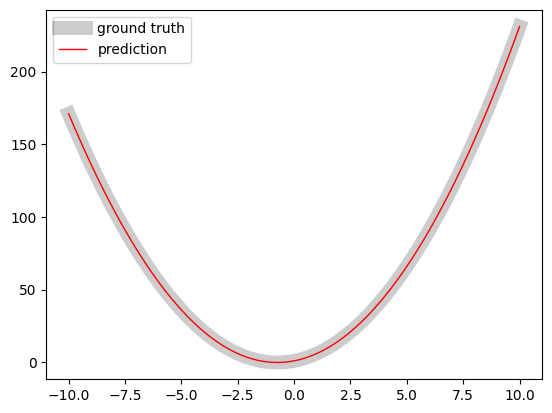

In [72]:
import matplotlib.pyplot as plt
x = np.linspace(-10, 10, 100).reshape((-1,1))
plt.plot(x, experiment_runner(x, noise_std=0.),
         label="ground truth",
         lw=10, alpha=0.2, c="black")
plt.plot(x, controller_loaded.state.models[-1].best_estimator_.predict(x),
         label="prediction",
         lw=1, alpha=1, c="red")
plt.legend()
